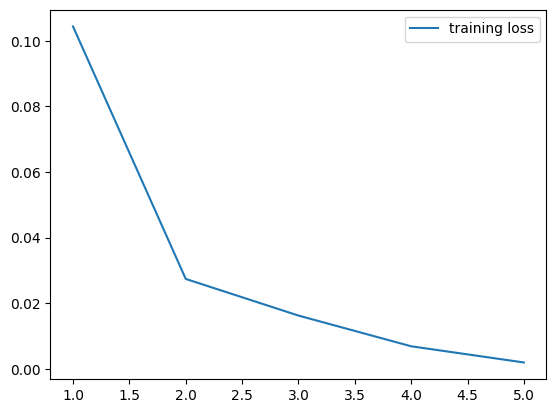

accuracy score 98.71428571428571


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder(root='data/image_dataset/train', transform=transform)
test_dataset = datasets.ImageFolder(root='data/image_dataset/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class PlaneCopterClassifier(nn.Module):
    def __init__(self):
        super(PlaneCopterClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128*8*8, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 128*8*8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = PlaneCopterClassifier().to(device)
criterion = nn.CrossEntropyLoss()
gd = optim.Adam(model.parameters(), lr=0.001)
losses = []

epochs = 5
for epoch in range(epochs):
    model.train()
    cur_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        gd.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        gd.step()

        cur_loss += loss.item()
    losses.append(cur_loss / len(train_loader))

plt.plot(range(1, epochs + 1), losses, label='training loss')
plt.legend()
plt.show()

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('accuracy score', 100 * correct / total)